# <a id=NotebookOrg> Notebook Organization </a> 

## 1. [City Overview](#CityCountyLevel)

## 2. [City Time Series Analytics](#CityTimeLevel)


## 3. [City Time Series Forecasting](#CityTimeForecastLevel)


## 4. [Home Level](#HomeLevel)

## 5. [City Level](#CityLevel)


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
import re 


from statsmodels.tsa.stattools import adfuller
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np



# <a id=CityCountyLevel>1. City Overview </a> 
[Back to Top](#NotebookOrg)

In [10]:
city_summ_df=pd.read_excel('Cities_Summary.xlsx','city summary')# Sheet name matches exactly the sheet that we want to open. 
del city_summ_df['Unnamed: 0']

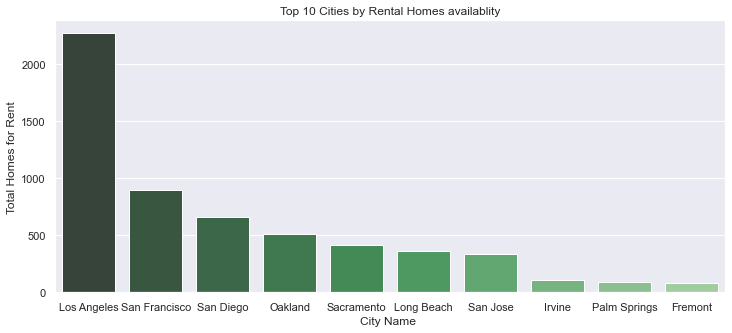

In [11]:
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(12,5)})
titanic = sns.load_dataset("titanic")
data = city_summ_df.groupby('City Name ').sum()['Total Homes for Rent'].sort_values(ascending=False)[:10]
pal = sns.color_palette("Greens_d", len(data))
rank = data.argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
sns.barplot(x=data.index, y=data, palette=np.array(pal[::1])[rank]).set_title('Top 10 Cities by Rental Homes availablity')
plt.show()

In [12]:
print('Number of Cities: ',len(city_summ_df))
print('Number of Cities: ',sum(city_summ_df['Total Homes for Rent']))
print('Share of Rentals from LA: ',city_summ_df.loc[city_summ_df['City Name ']=='Los Angeles']['Total Homes for Rent']/sum(city_summ_df['Total Homes for Rent']))

Number of Cities:  20
Number of Cities:  6092
Share of Rentals from LA:  7    0.372948
Name: Total Homes for Rent, dtype: float64


# <a id=CityTimeLevel>2. City Time Series </a> 
[Back to Top](#NotebookOrg)

In [13]:
city_timeseries=pd.read_table('CityLevel.csv',sep='|')# Sheet name matches exactly the sheet that we want to open. 

# Data Cleaning: 
city_timeseries['month_date_formatted'] = [(datetime.strptime(x, '%b-%y').strftime('%Y-%m')) for x in city_timeseries['Month of Period End']]
city_timeseries['Median Sale PriceFixed'] = [int(''.join(re.findall('\d+',x))) for x in city_timeseries['Median Sale Price']]

In [14]:
plot_1_data = city_timeseries[city_timeseries['month_date_formatted']>= '2019-07'][['Region','month_date_formatted','Median Sale PriceFixed']]
plot_1_data = plot_1_data[plot_1_data['month_date_formatted']<'2022-01']

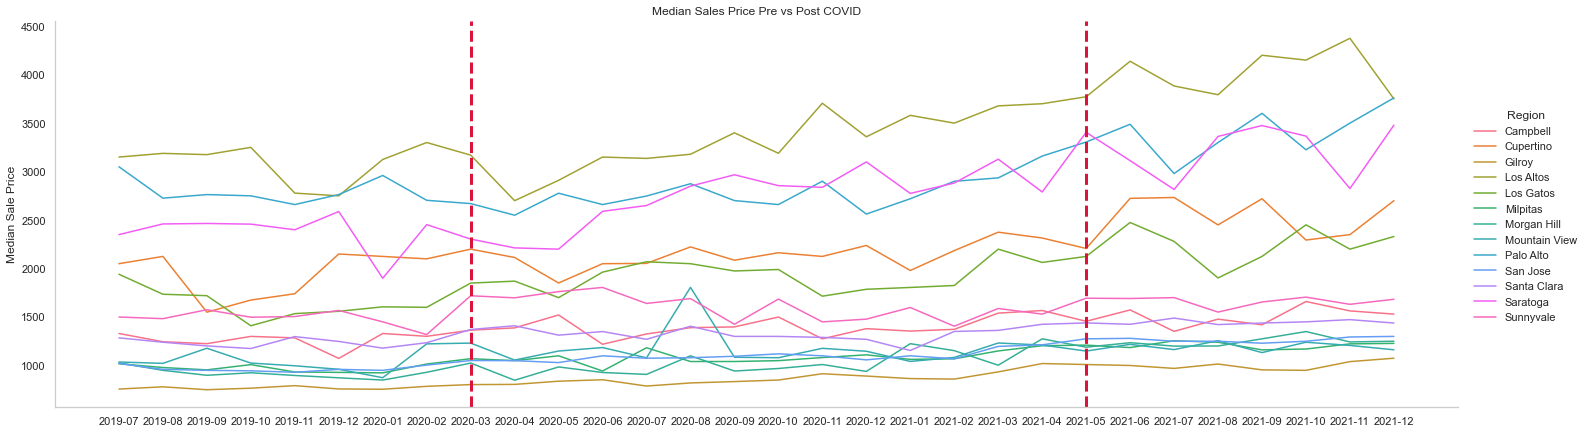

In [15]:
sns.set_style("whitegrid", {'axes.grid' : False})
kdeplot = sns.relplot(
    data=plot_1_data, 
    x="month_date_formatted", y="Median Sale PriceFixed", hue="Region",
    height=6, aspect=3.4, 
    kind="line"
).set(
    title="Median Sales Price Pre vs Post COVID", 
    ylabel="Median Sale Price",
    xlabel=None
)
for ax in kdeplot.axes.flat:
    ax.axvline(8, color='crimson', ls='--', lw=3)
    ax.axvline(22, color='crimson', ls='--', lw=3)

# <a id=CityTimeForecastLevel>2. City Time Series Forecast </a> 
[Back to Top](#NotebookOrg)

### Step 1: Exploratory Data Analysis to analyze the Seasonlity and trend 

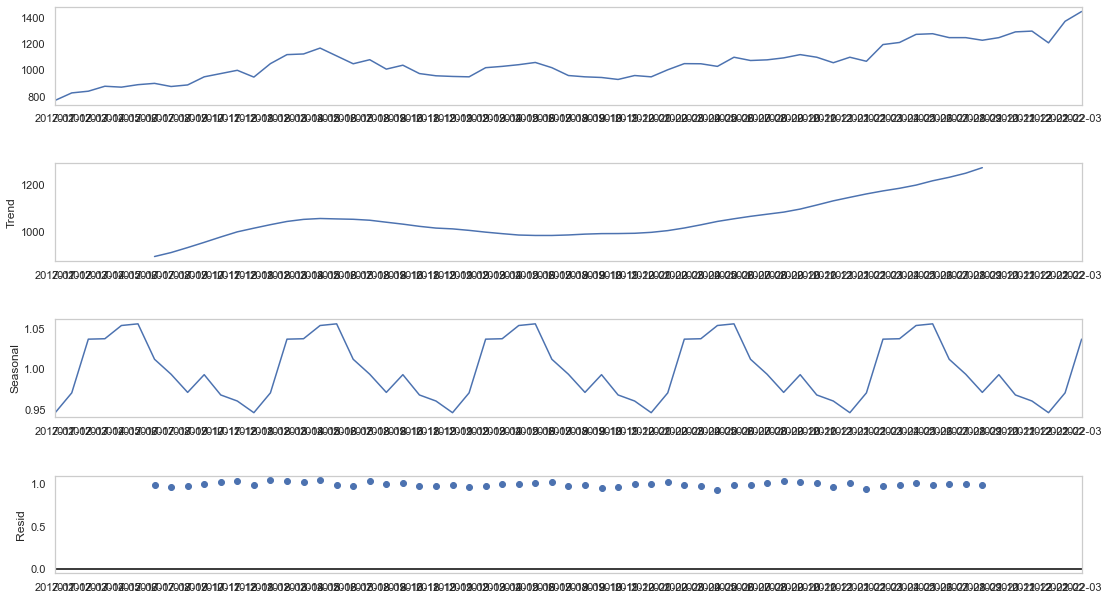

In [16]:
sanjose_df = city_timeseries[city_timeseries['Region']== 'San Jose'][['month_date_formatted','Median Sale PriceFixed']]
sanjose_df = sanjose_df[sanjose_df['month_date_formatted']>='2017-01']

# city_timeseries.sort_index(inplace=True)
# #Do all of the above using  one line of code!
sanjose_df['Date'] =  [(datetime.strptime(x, '%Y-%m').strftime('%Y-%m')) for x in sanjose_df['month_date_formatted']]
sanjose_df = sanjose_df.set_index('Date')

del sanjose_df['month_date_formatted']

from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(sanjose_df, model='multiplicative',period=12)

fig = components.plot()
fig.set_size_inches((16, 9))
plt.show()


### Step 2: Does it have auto correlation?

In [17]:
dftest = adfuller(sanjose_df['Median Sale PriceFixed'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

# Pvalue is greater than threshold need to perform autocorrelation

Test Statistic                 -0.639507
p-value                         0.861803
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


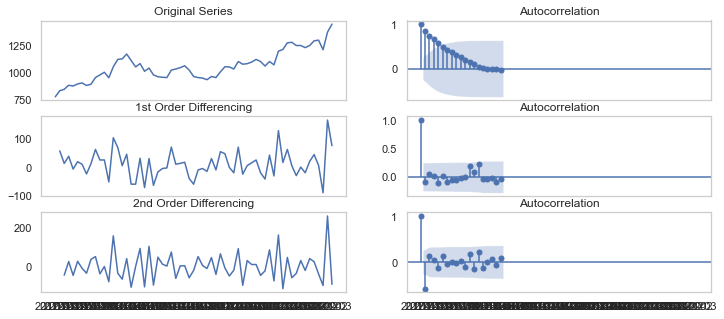

In [19]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(sanjose_df['Median Sale PriceFixed']); axes[0, 0].set_title('Original Series')
plot_acf(sanjose_df['Median Sale PriceFixed'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(sanjose_df['Median Sale PriceFixed'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(sanjose_df['Median Sale PriceFixed'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(sanjose_df['Median Sale PriceFixed'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(sanjose_df['Median Sale PriceFixed'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

### Step 3: Train-Test Split

In [25]:
# Create Training and Test 70-30 split 
train = sanjose_df[:44]['Median Sale PriceFixed']
test = sanjose_df[44:]['Median Sale PriceFixed']

### Step 4: Try on 3 different models

C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

                                ARIMA Model Results                                 
Dep. Variable:     D.Median Sale PriceFixed   No. Observations:                   43
Model:                       ARIMA(1, 1, 1)   Log Likelihood                -220.254
Method:                             css-mle   S.D. of innovations             40.579
Date:                      Wed, 11 May 2022   AIC                            448.508
Time:                              17:36:37   BIC                            455.553
Sample:                          02-01-2017   HQIC                           451.106
                               - 08-01-2020                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              7.2440      6.361      1.139      0.255      -5.223      19.711
ar.L1.D.Median Sale Pri

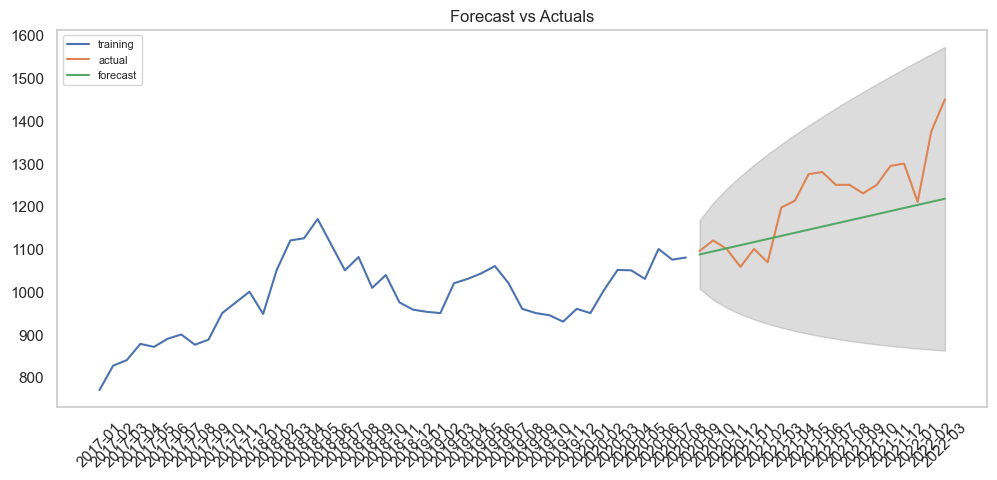

In [26]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(19, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xticks(rotation = 45)
plt.legend(loc='upper left', fontsize=8)
plt.show()

C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

                                 ARIMA Model Results                                 
Dep. Variable:     D2.Median Sale PriceFixed   No. Observations:                   42
Model:                        ARIMA(3, 2, 1)   Log Likelihood                -216.562
Method:                              css-mle   S.D. of innovations             40.341
Date:                       Wed, 11 May 2022   AIC                            445.124
Time:                               17:37:06   BIC                            455.550
Sample:                           03-01-2017   HQIC                           448.945
                                - 08-01-2020                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.4507      0.611     -0.737      0.461      -1.649       0.747
ar.L1.D2.Med

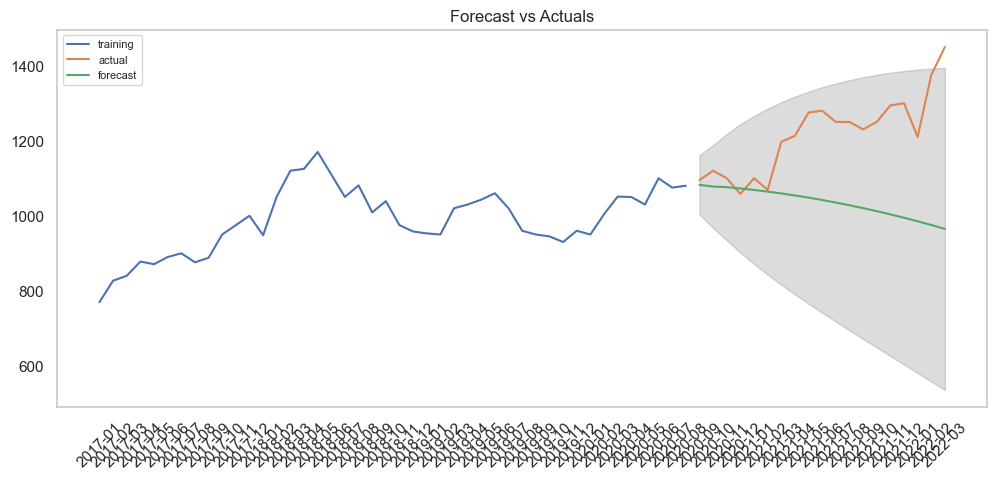

In [27]:
# Build Model 2
model = ARIMA(train, order=(3,2, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(19, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')

plt.xticks(rotation = 45)
plt.legend(loc='upper left', fontsize=8)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=464.951, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=450.830, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=462.970, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=447.259, Time=0.04 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=449.258, Time=0.07 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=449.083, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=445.319, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=448.887, Time=0.01 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=447.319, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=447.144, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=441.088, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=439.091, Time=0.0

TypeError: fill_between() missing 1 required positional argument: 'y1'

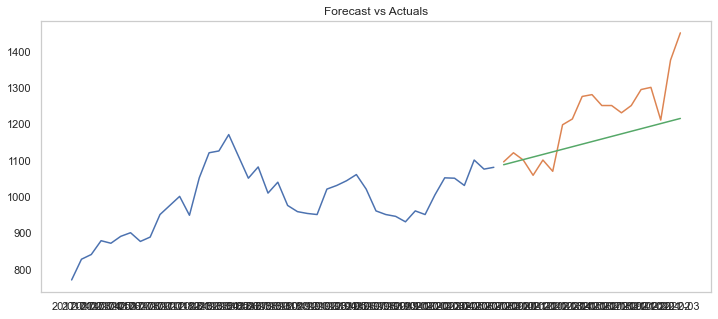

In [28]:
# Build AUTOMATED ARIMA MODEL
# AUTOMATED ARIMA 
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# Build Model
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)  

plt.title('Forecast vs Actuals')

# Forecast
fc, se = model.predict(n_periods=19, return_conf_int=True)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xticks(rotation = 45)
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [29]:
# TEST FOR RMSE ON ALL THREE MODELS INDIVIDUALLY 
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\sarah\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'mape': 0.06156316498512358,
 'me': -65.85724999246973,
 'mae': 78.5302807418189,
 'mpe': -0.04970274506758482,
 'rmse': 97.73487939575307,
 'acf1': 0.5021050831519684,
 'corr': 0.8662692558413986,
 'minmax': 0.061313955763243166}

In [30]:
# FINAL MODEL

# #!pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
model = pm.auto_arima(sanjose_df['Median Sale PriceFixed'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=660.642, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=657.145, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=658.667, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=658.696, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=658.444, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.116 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   63
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -326.573
Date:                Wed, 11 May 2022   AIC                            657.145
Time:                        17:38:36   BIC                            661.400
Sample:                             0   HQIC                           658.816
                                 - 63                                         
Co

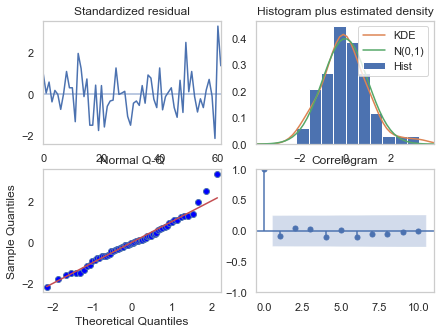

In [31]:

model.plot_diagnostics(figsize=(7,5))
plt.show()

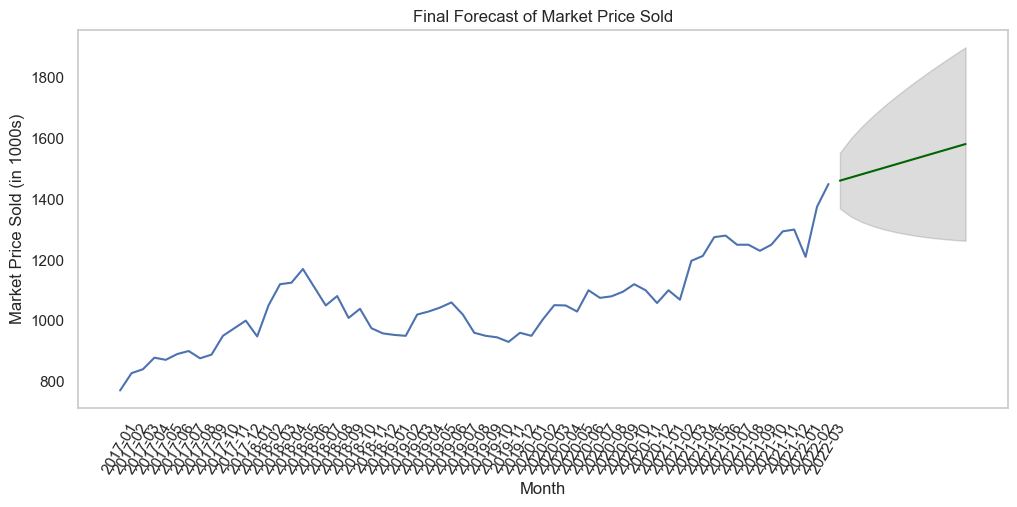

In [32]:
# Forecast
n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(sanjose_df['Median Sale PriceFixed'],), len(sanjose_df['Median Sale PriceFixed'],)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(sanjose_df['Median Sale PriceFixed'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xticks(rotation = 60)
plt.title("Final Forecast of Market Price Sold")

plt.xlabel("Month")
plt.ylabel("Market Price Sold (in 1000s)")
plt.show()

In [33]:
# FORECASTED NUMBERS FOR NEXT 12 months 
fc_series

63    1460.967742
64    1471.935484
65    1482.903226
66    1493.870968
67    1504.838710
68    1515.806452
69    1526.774194
70    1537.741935
71    1548.709677
72    1559.677419
73    1570.645161
74    1581.612903
dtype: float64

In [34]:
sanjose_df[20:]

,Median Sale PriceFixed
Date,
2018-09,1009
2018-10,1039
2018-11,975
2018-12,958
2019-01,953
2019-02,950
2019-03,1020
2019-04,1030
2019-05,1043


# <a id=HomeLevel>4. Home Level </a> 
[Back to Top](#NotebookOrg)

In [4]:
homes_df=pd.read_excel('Group2_HomeData.xlsx','homes', index_col=0)# Sheet name matches exactly the sheet that we want to open. 
homes_df

,City,Bed Bath Sqft,Price,Address,URL,Walk Score,Transit Score,Bike Score,Places Nearby,Storm Risk,...,Status,Property Type,Hoa Dues,Year Built,Community,Lot Size,Time on Redfin,Redfin Estimate,Price Per Sq.Ft.,Buyers Agent Commission
0,Cupertino,"4 Beds2.5 Baths2,270 Sq. Ft.",2580000,"10551 Glenview Ave, CUPERTINO, CA 95014",https://www.redfin.com//CA/Cupertino/10551-Gle...,54,44,67,NaN,Moderate,...,Sold,Single Family Home,0,2005,CUPERTINO,"6,300",0,"3,617,355","1,594",2.5
1,Cupertino,"2 Beds2 Baths1,171 Sq. Ft.",1170000,"20488 Stevens Creek Blvd #2210, CUPERTINO, CA ...",https://www.redfin.com//CA/Cupertino/20488-Ste...,82,48,77,NaN,Moderate,...,Sold,Condo,556,2003,CUPERTINO,"1,677",0,"1,173,345","1,002",2.5
2,Cupertino,"3 Beds2 Baths1,196 Sq. Ft.",1830000,"18861 Barnhart Ave, CUPERTINO, CA 95014",https://www.redfin.com//CA/Cupertino/18861-Bar...,41,41,67,NaN,Moderate,...,Sold,Single Family Home,0,1953,CUPERTINO,"5,409",0,"2,627,615","2,197",2.5
3,Cupertino,"3 Beds2 Baths1,115 Sq. Ft.",2120000,"7652 W Hill Ln, CUPERTINO, CA 95014",https://www.redfin.com//CA/Cupertino/7652-W-Hi...,22,33,47,NaN,Moderate,...,Sold,Single Family Home,0,1965,CUPERTINO,"6,179",0,"2,725,279","2,444",2.5
4,Cupertino,"2 Beds1.5 Baths1,216 Sq. Ft.",1300000,"10367 Mary Ave, CUPERTINO, CA 95014",https://www.redfin.com//CA/Cupertino/10367-Mar...,39,41,73,NaN,Moderate,...,Sold,Townhouse,398,1971,CUPERTINO,537,0,"1,357,211","1,069",2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,Morgan-Hill,—Beds—Baths—Sq. Ft.,1899000,"19900 Dougherty Ave, MORGAN HILL, CA 95037",https://www.redfin.com//CA/Morgan-Hill/19900-D...,6,0,39,NaN,Moderate,...,Active,Residential Development Land,0,9999,MORGAN HILL,11.98 Acres,54 days,0,0,2.5
594,Morgan-Hill,—Beds—Baths—Sq. Ft.,240000,"0 Croy Rd, MORGAN HILL, CA 95037",https://www.redfin.com//CA/MORGAN-HILL/CROY-RD...,0,0,0,NaN,Moderate,...,Active,Residential Development Land,0,9999,MORGAN HILL,13 Acres,74 days,0,0,3
595,Morgan-Hill,—Beds—Baths0.62 Acre (Lot),375000,"17585 Blue Jay Dr, MORGAN HILL, CA 95037",https://www.redfin.com//CA/Morgan-Hill/17585-B...,1,0,8,NaN,Moderate,...,Active,Residential Lot,73,9999,MORGAN HILL,0.62 Acres,89 days,"370,095",0,2.5
596,Morgan-Hill,—Beds—Baths2.01 Acres (Lot),296000,"14055 Prom Dr, MORGAN HILL, CA 95037",https://www.redfin.com//CA/Morgan-Hill/14055-P...,1,0,0,NaN,Moderate,...,Active,Residential Lot,0,9999,MORGAN HILL,2.01 Acres,90 days,"286,204",0,2.5


## <font color = 'teal'> Analysis of the scraped housing data

In [5]:
homes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 598 entries, 0 to 597
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   City                     598 non-null    object 
 1   Bed Bath Sqft            598 non-null    object 
 2   Price                    598 non-null    int64  
 3   Address                  598 non-null    object 
 4   URL                      598 non-null    object 
 5   Walk Score               598 non-null    int64  
 6   Transit Score            598 non-null    int64  
 7   Bike Score               598 non-null    int64  
 8   Places Nearby            0 non-null      float64
 9   Storm Risk               598 non-null    object 
 10  Drought Risk             598 non-null    object 
 11  Heat Risk                598 non-null    object 
 12  Fire Risk                598 non-null    object 
 13  Status                   598 non-null    object 
 14  Property Type            5

### <font color = 'teal'> 1. Plotting a heatmap to check for Null Values in columns

<AxesSubplot:>

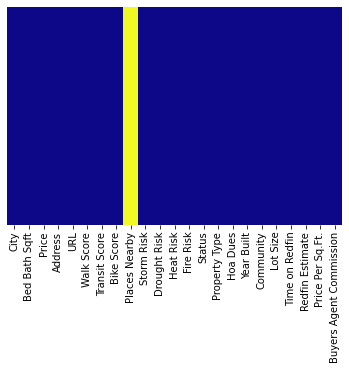

In [6]:
sns.heatmap(homes_df.isnull(),yticklabels=False,cbar=False,cmap='plasma')

In [7]:
# REMOVING MISSING VALUES FROM DATA SO THAT THE DATA MODELS ARE UNBIASED

homes_df.drop('Places Nearby', axis=1, inplace=True)

### <font color = 'teal'> 2. Status column can be used to compare the sold houses to the currently active houses in terms of price

In [8]:
homes_df['Status'].value_counts() 

Sold      320
Active    278
Name: Status, dtype: int64

### <font color = 'teal'> 3. Property Type column can be used to give insight on the types of property that are sold or are currently active in the market

In [9]:
homes_df['Property Type'].value_counts()

Single Family Home                      384
Condo                                    77
Townhouse                                74
Single Family Residential                17
Residential Lot                           9
Double-Wide Mobile Home                   9
Residential Development Land              8
Duplex                                    5
Fourplex                                  3
Triplex                                   2
Single-Wide Mobile Home                   2
Other Residential Land (See Remarks)      2
Mobile/Manufactured Home                  1
Triple-Wide Mobile Home                   1
5+ Units                                  1
Agriculture/Ranch Land                    1
Vacant Land                               1
Condominium                               1
Name: Property Type, dtype: int64

<font color = 'teal'> 'Single Family Residential', 'Single Family, Residential Single-Family' and 'Single Family Residence' can be all combined under ''Single Family Home'

In [10]:
homes_df['Property Type']=homes_df['Property Type'].str.replace('Single Family Residential','Single Family Home')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Single Family, Residential Single-Family','Single Family Home')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Single Family Residence','Single Family Home')

<font color = 'teal'>'Agriculture/Ranch Land', 'Residential Lot', 'Vacant Land', 'Other Residential Land (See Remarks)' and 'Residential Development Land' can be all combined under 'Land'

In [11]:
homes_df['Property Type']=homes_df['Property Type'].str.replace('Agriculture/Ranch Land','Land')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Residential Lot','Land')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Residential Development Land','Land')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Vacant Land','Land')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Other Residential Land \(See Remarks\)','Land')

<ipython-input-11-a762133b3487>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  homes_df['Property Type']=homes_df['Property Type'].str.replace('Other Residential Land \(See Remarks\)','Land')


<font color = 'teal'>'Single-Wide Mobile Home', 'Single-Wide Mobile Home' and 'Mobile/Manufactured Home' can be all combined under 'Mobile Home'

In [13]:
homes_df['Property Type']=homes_df['Property Type'].str.replace('Single-Wide Mobile Home','Mobile Home')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Double-Wide Mobile Home','Mobile Home')
homes_df['Property Type']=homes_df['Property Type'].str.replace('Mobile/Manufactured Home','Mobile Home')

<font color = 'teal'>'Condominium' can be combined under 'Condo'

In [14]:
homes_df['Property Type']=homes_df['Property Type'].str.replace('Condominium','Condo')

### <font color = 'teal'> 4. 'Redfin Estimate' and 'Price Per Sq.Ft.' column need to be cleaned to remove $ and , from the values

In [15]:
#Checking range of Prices
homes_df['Price']

0      2580000
1      1170000
2      1830000
3      2120000
4      1300000
        ...   
593    1899000
594     240000
595     375000
596     296000
597     350000
Name: Price, Length: 598, dtype: int64

In [16]:
homes_df['Redfin Estimate'] = homes_df['Redfin Estimate'].str.replace('$','')
homes_df['Redfin Estimate'] = homes_df['Redfin Estimate'].str.replace(',','')
#homes_df['Redfin Estimate']

<ipython-input-16-ffdd4c7cdd72>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  homes_df['Redfin Estimate'] = homes_df['Redfin Estimate'].str.replace('$','')


In [17]:
homes_df['Price Per Sq.Ft.'] = homes_df['Price Per Sq.Ft.'].str.replace('$','')
homes_df['Price Per Sq.Ft.'] = homes_df['Price Per Sq.Ft.'].str.replace(',','')
#homes_df['Price Per Sq.Ft.']

<ipython-input-17-39f7bdeca720>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  homes_df['Price Per Sq.Ft.'] = homes_df['Price Per Sq.Ft.'].str.replace('$','')


### <font color = 'teal'> 5. 'Price', 'Redfin Estimate' and 'Price Per Sq.Ft.' columns are converted to float type for further analysis

In [18]:
homes_df['Price'] = homes_df['Price'].astype(float)
homes_df['Redfin Estimate'] = homes_df['Redfin Estimate'].astype(float)
homes_df['Price Per Sq.Ft.'] = homes_df['Price Per Sq.Ft.'].astype(float)

In [19]:
homes_df['Storm Risk'].value_counts()

Moderate    482
High        116
Name: Storm Risk, dtype: int64

In [20]:
homes_df['Year Built'].value_counts()

1977    22
1960    22
9999    21
1976    19
1959    18
        ..
1935     1
1937     1
1939     1
1946     1
1922     1
Name: Year Built, Length: 95, dtype: int64

In [21]:
homes_df['Community'].value_counts()
homes_df['Community']=homes_df['Community'].str.replace('SUNNYVALE','Sunnyvale')
homes_df['Community']=homes_df['Community'].str.replace('SANTA CLARA','Santa Clara')
homes_df['Community']=homes_df['Community'].str.replace('CUPERTINO','Cupertino')
homes_df['Community']=homes_df['Community'].str.replace('SAN JOSE','San Jose')


### <font color = 'teal'> 6. Rename the columns 

In [22]:
homes_df.rename(columns = {'Price Per Sq.Ft.':'price_per_sqft'}, inplace = True)
homes_df.rename(columns = {'Bike Score':'bike_score'}, inplace = True)
homes_df.rename(columns = {'Walk Score':'walk_score'}, inplace = True)
homes_df.rename(columns = {'Transit Score':'transit_score'}, inplace = True)

# <a id=CityLevel>5. City Level </a> 
[Back to Top](#NotebookOrg)
## <font color = 'teal'> Data Visualization

### <font color = 'teal'> House Prices across different cities

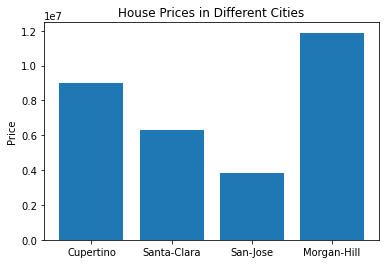

In [23]:
x= homes_df['City']
y =homes_df['Price'] 
plt.bar(x, y, align='center') 
plt.ylabel('Price')
plt.title('House Prices in Different Cities') 
#plt.ylim([0,2.4])
plt.show()

In [25]:
homes_df.describe()

,Price,walk_score,transit_score,bike_score,Year Built,Redfin Estimate,price_per_sqft
count,5.980000e+02,598.000000,598.000000,598.000000,598.000000,5.620000e+02,577.000000
mean,1.740618e+06,43.364548,29.617057,59.036789,2258.478261,1.979934e+06,1064.838821
std,1.061578e+06,23.858479,16.649068,23.334907,1478.097738,1.123425e+06,465.911647
min,1.399000e+05,0.000000,0.000000,0.000000,1901.000000,1.430190e+05,146.000000
25%,1.050500e+06,24.000000,20.000000,48.250000,1960.000000,1.228061e+06,731.000000
50%,1.504000e+06,45.000000,34.000000,65.000000,1976.000000,1.765455e+06,928.000000
75%,2.200000e+06,62.000000,41.000000,76.000000,1994.000000,2.575931e+06,1325.000000
max,1.188800e+07,92.000000,70.000000,95.000000,9999.000000,1.183574e+07,3124.000000


### <font color = 'teal'> 1. Histogram plot for the numeric attributes of the dataframe

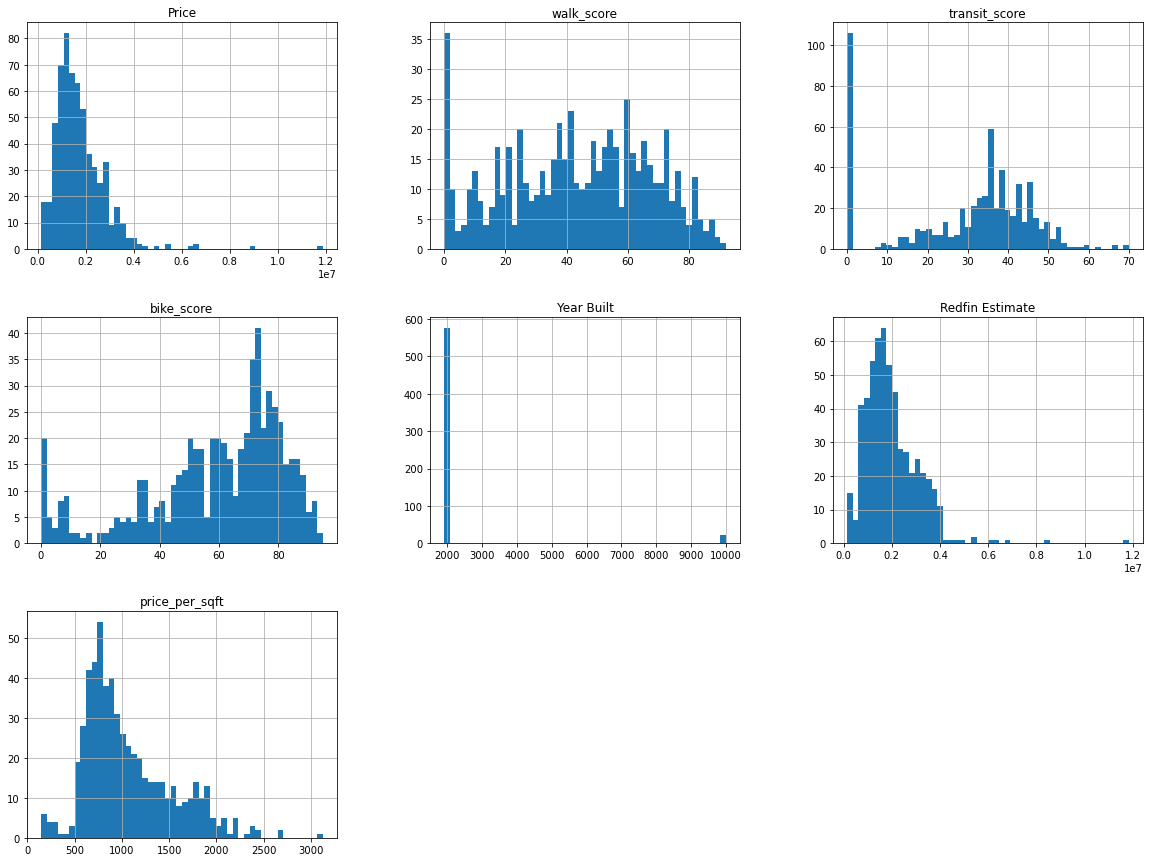

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
homes_df.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [27]:
corr_matrix = homes_df.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price              1.000000
Redfin Estimate    0.954337
price_per_sqft     0.506100
Year Built         0.035959
walk_score        -0.092992
bike_score        -0.107563
transit_score     -0.185100
Name: Price, dtype: float64

In [28]:
len(homes_df['Community'].value_counts())

24

### <font color = 'teal'> 2. Comparison between 'Price per Sqft' and 'Address' grouped by the community they belong to

In [30]:
freq = homes_df.groupby('Community').count()['Address']
mean = homes_df.groupby('Community').mean()['price_per_sqft']
cluster = pd.concat([freq, mean], axis=1)
cluster['Community'] = cluster.index
cluster.columns = ['freq', 'price_per_sqft','Community']
cluster.describe()

,freq,price_per_sqft
count,24.000000,24.000000
mean,24.875000,1056.771081
std,52.621134,309.549225
min,1.000000,439.000000
25%,1.000000,908.250000
50%,1.000000,986.000000
75%,4.250000,1189.911972
max,155.000000,1922.200000


In [31]:
cluster1 = cluster[cluster.price_per_sqft < 1000]
cluster1.index

Index(['ALVISO', 'Almaden', 'BROOKLINE PLACE', 'Central San Jose', 'Downtown',
       'Lawrence', 'MORGAN HILL', 'MOUNTAIN VIEW', 'Mission Rnch',
       'Morgan Hill', 'Mountain View', 'San Jose', 'Sunnyvale Meadows'],
      dtype='object', name='Community')

In [32]:
cluster_temp = cluster[cluster.price_per_sqft >= 1000]
cluster2 = cluster_temp[cluster_temp.freq <100]
cluster2.index

Index(['Apex at Lawrence Station', 'CAMPBELL', 'Gardens Of Sunn.', 'LOS ALTOS',
       'Ponderosa', 'SAN MARTIN', 'SARATOGA', 'Santa Clara', 'Willow Glen'],
      dtype='object', name='Community')

In [33]:
cluster3 = cluster_temp[cluster_temp.freq >=100]
cluster3.index

Index(['Cupertino', 'Sunnyvale'], dtype='object', name='Community')

In [34]:
def get_group(x):
    if x in cluster1.index:
        return 'low_price'
    elif x in cluster2.index:
        return 'high_price_low_freq'
    else:
        return 'high_price_high_freq'
homes_df['group'] = homes_df.Community.apply(get_group)

### <font color = 'teal'> 3. Boxplot to identify outliers in the price

<AxesSubplot:>

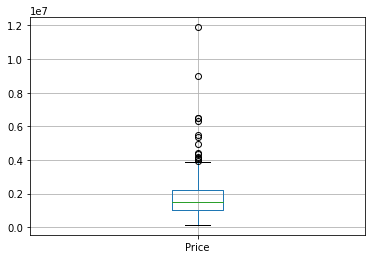

In [36]:
#Boxplot showing that there are more number of outliers on the higher range of price
homes_df.boxplot(column=['Price'])

### <font color = 'teal'> 4. Distribution of 'Price' in the cities chosen

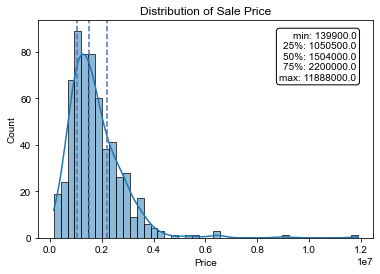

In [37]:
# Plotted the prices of all the counties to see how well the data is distributed. 
# We can conclude that price is positively skewed and mean > mode 
# which tells that there are outliers on the higher range of price of house listing
x = 'Price'
fig, ax = plt.subplots()
ax.title.set_text('Distribution of Sale Price')
variable = homes_df[x].fillna(homes_df[x].mean())
sns.histplot(variable, kde=True)
des = homes_df[x].describe()
ax.axvline(des["25%"], ls='--')
ax.axvline(des["50%"], ls='--')
ax.axvline(des["75%"], ls='--')
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "50%: "+des["50%"], "75%: "+des["75%"], "max: "+des["max"]))
ax.text(0.95, 0.95, box, transform=ax.transAxes, fontsize=10, va='top', 
        ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
sns.set(rc={'figure.figsize':(20,18)})

plt.show()

### <font color = 'teal'> 5. Top City vs Bottom City based on 'Price per Sqft'

In [34]:
# Top and Bottom city in CA as per the Average price per square feet
#Average price of price_per_sqft for all the cities of Northern California

a = homes_df.groupby(by="City")
b = pd.DataFrame(a['price_per_sqft'].mean().round(2))
Top = pd.DataFrame(b.sort_values(by = 'price_per_sqft',ascending=False).head(1))
print(Top)
Top['Stack'] = 'Top'

Bottom = pd.DataFrame(b.sort_values(by = 'price_per_sqft',ascending=False).tail(1))
print(Bottom)
Bottom['Stack'] = 'Bottom'

           price_per_sqft
City                     
Cupertino          1498.5
             price_per_sqft
City                       
Morgan-Hill          695.64


### <font color = 'teal'> 6. Communities in the selected cities as per the average price per sqft.

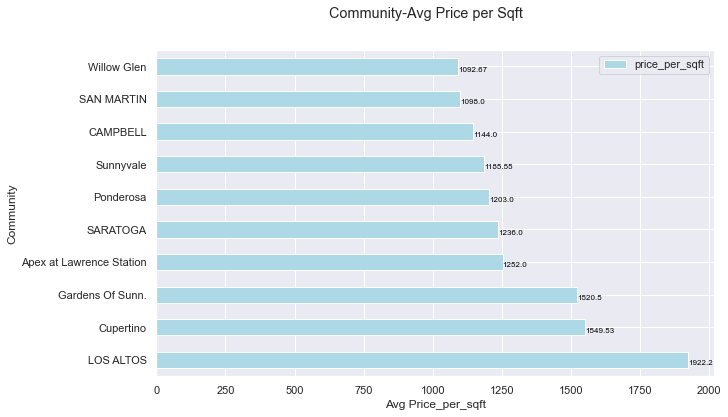

In [38]:
# communities in CA as per the Average price per square feet

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
# Top 10 communities in Southbay as per the Average price per square feet

a = homes_df.groupby(by="Community")
b = pd.DataFrame(a['price_per_sqft'].mean().round(2))
Top10 = pd.DataFrame(b.sort_values(by = 'price_per_sqft',ascending=False).head(10))
Top10['Stack'] = 'Top'
 
# Horizontal Bar Plot
ax = Top10.plot(kind='barh',color='lightblue',figsize=(10,6))
plt.xlabel("Avg Price_per_sqft")
plt.ylabel("Community") 

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.4, i.get_y()+0.1,
             str(round((i.get_width()), 2)),
             fontsize = 8, color ='black')
    
plt.suptitle('Community-Avg Price per Sqft')
# Show Plot
plt.show()

### <font color = 'teal'> 7. Catplot of walkscore and bikescores across cities

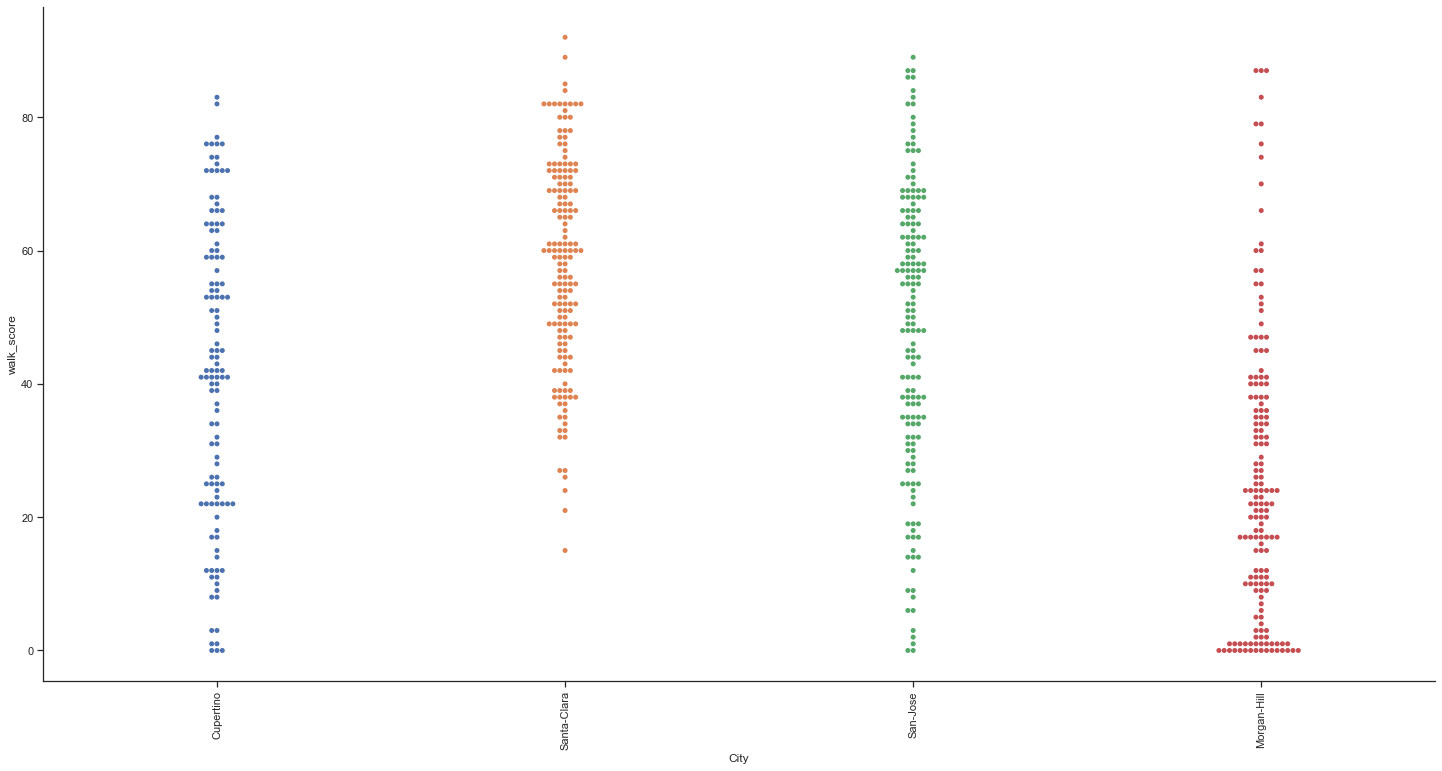

In [39]:
#Catplot of walkscore and bike score to check range of scores city wise
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')
new_df = homes_df.dropna(subset=['City', 'walk_score', 'bike_score','transit_score'])

sns.set_theme(style="ticks", color_codes=True)
g = sns.catplot(x="City", y="walk_score", data=new_df, height=10, aspect=20/10, kind='swarm')
g.set_xticklabels(rotation=90)

### <font color = 'teal'> 8. Catplot of bikescore across cities

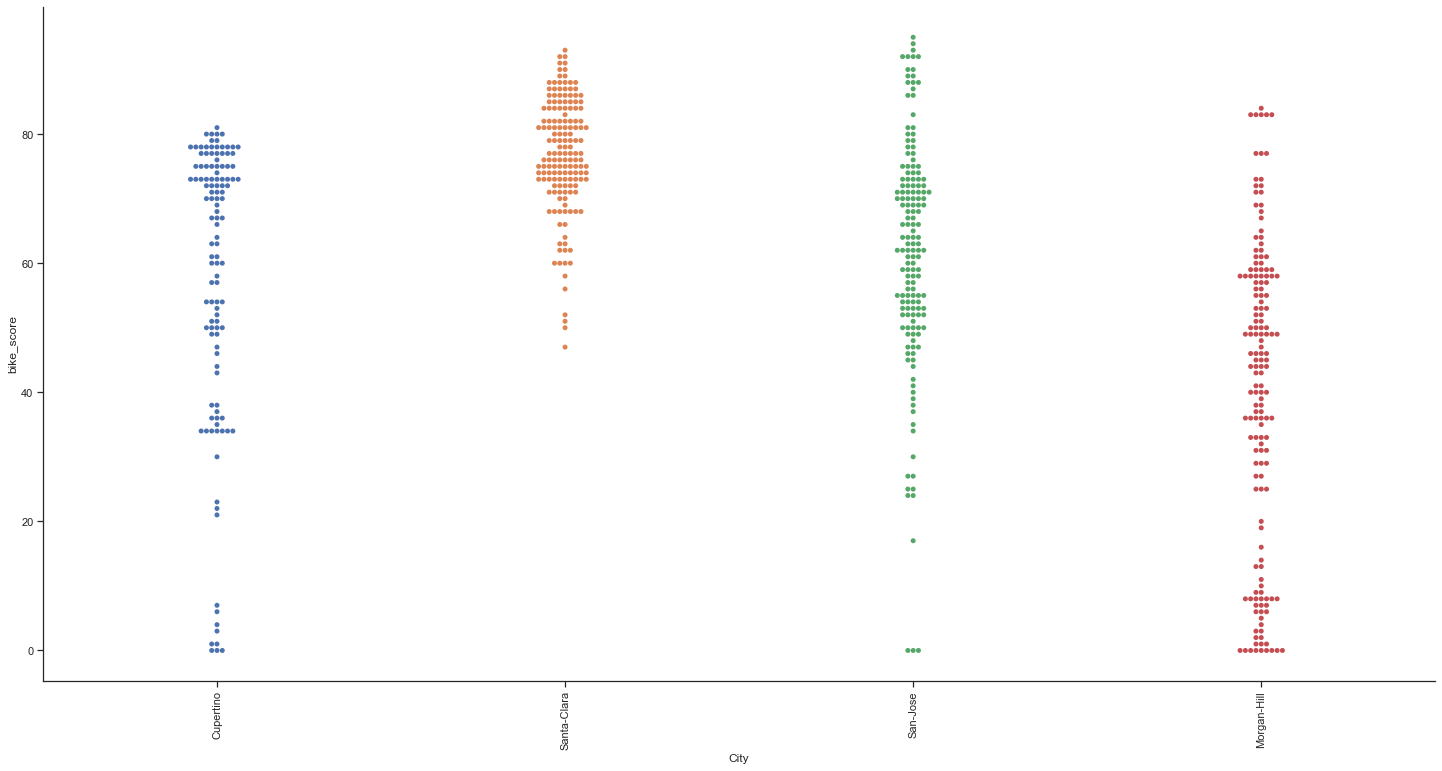

In [40]:
g = sns.catplot(x="City", y="bike_score", data=new_df, height=10, aspect=20/10, kind='swarm')
g.set_xticklabels(rotation=90)

### <font color = 'teal'> 9. Catplot of transit score across cities

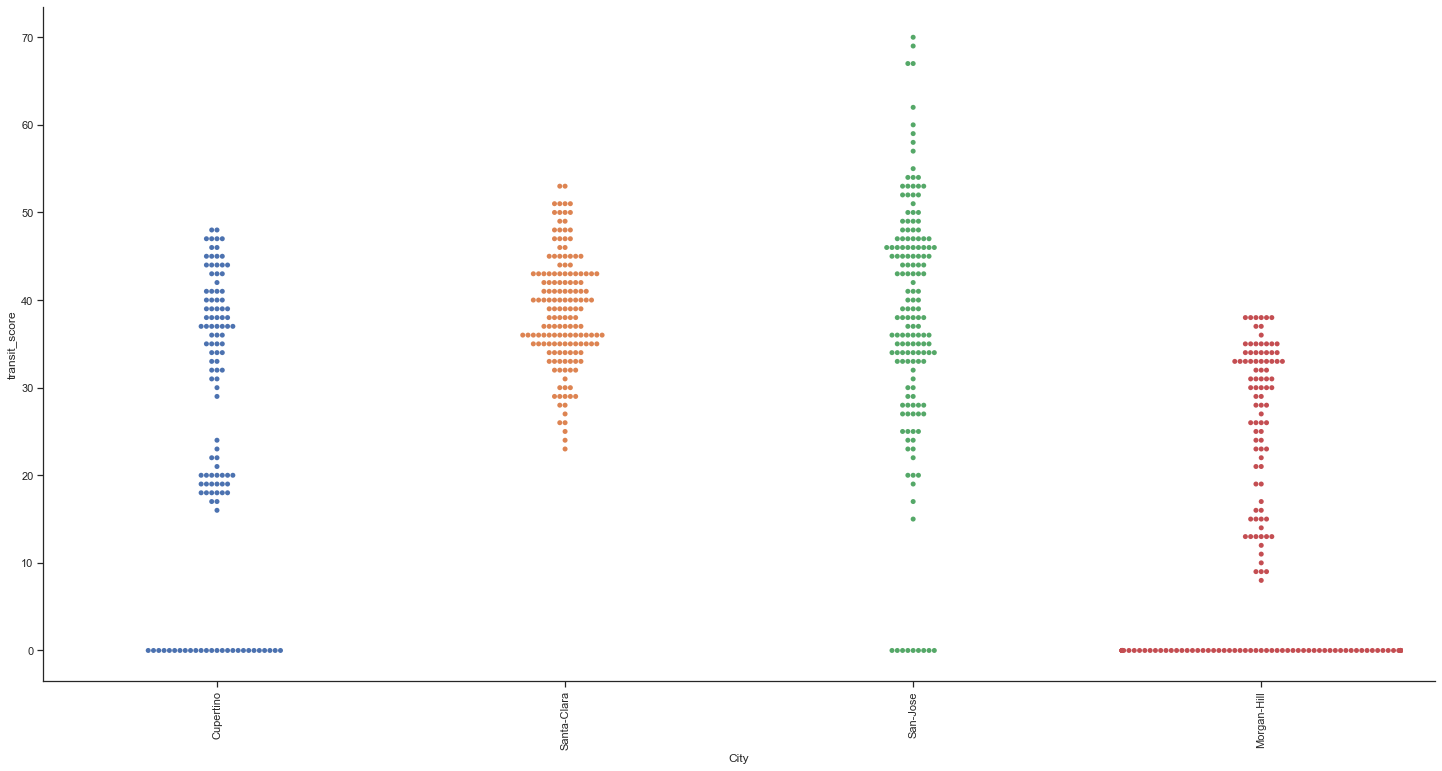

In [41]:
g = sns.catplot(x="City", y="transit_score", data=new_df, height=10, aspect=20/10, kind='swarm')
g.set_xticklabels(rotation=90)

### <font color = 'teal'> 10. Categorizing scores into ordinal categories

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Cupertino'),
  Text(1, 0, 'San-Jose'),
  Text(2, 0, 'Santa-Clara'),
  Text(3, 0, 'Morgan-Hill')])

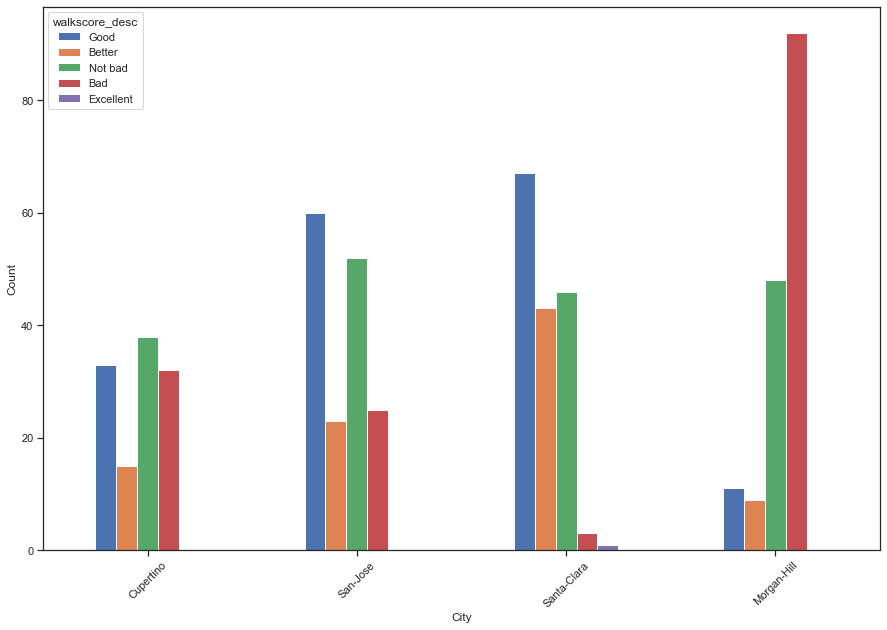

In [42]:
#Categorizing scores into ordinal categories
walkscore_desc_list = []
for t in homes_df['walk_score']:
    if t <= 100 and t >= 90:
        walkscore_desc_list.append('Excellent')
    elif t <= 89 and t >= 70:
        walkscore_desc_list.append('Better')
    elif t <= 69 and t >= 50:
        walkscore_desc_list.append('Good')
    elif t <= 49 and t >= 25:
        walkscore_desc_list.append('Not bad')
    elif t <= 24 and t >= 0:
        walkscore_desc_list.append('Bad')
    else:
        walkscore_desc_list.append('')
homes_df['walkscore_desc'] = walkscore_desc_list
g = pd.crosstab(homes_df['City'], homes_df['walkscore_desc'])
City_list = ['Cupertino','San-Jose','Santa-Clara','Morgan-Hill']
unique_ts = list(homes_df['walkscore_desc'].unique())
g.loc[City_list, unique_ts].plot.bar(figsize=(15,10))
plot.xlabel('City')
plot.ylabel('Count')
plot.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Cupertino'),
  Text(1, 0, 'San-Jose'),
  Text(2, 0, 'Santa-Clara'),
  Text(3, 0, 'Morgan-Hill')])

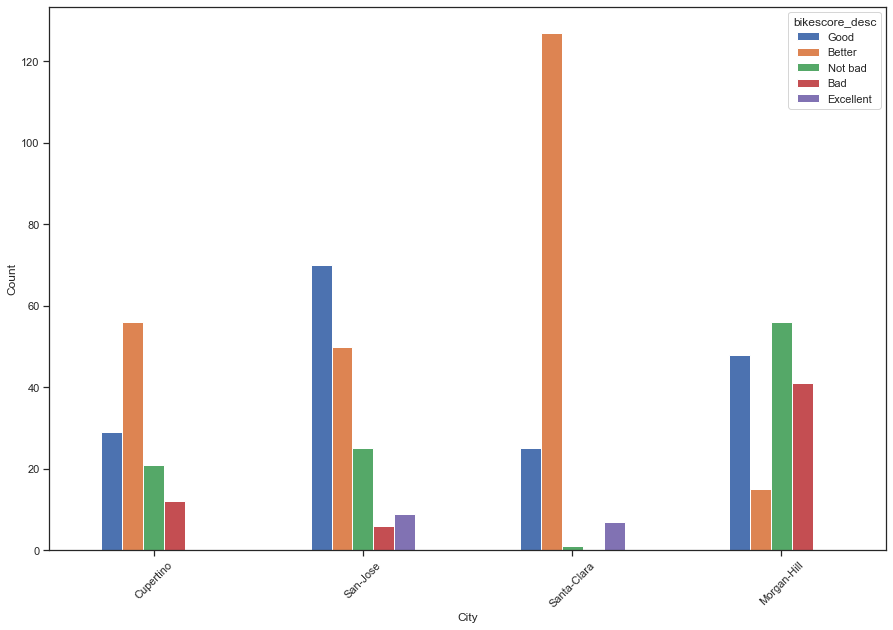

In [43]:
bikescore_desc_list = []
for t in homes_df['bike_score']:
    if t <= 100 and t >= 90:
        bikescore_desc_list.append('Excellent')
    elif t <= 89 and t >= 70:
        bikescore_desc_list.append('Better')
    elif t <= 69 and t >= 50:
        bikescore_desc_list.append('Good')
    elif t <= 49 and t >= 25:
        bikescore_desc_list.append('Not bad')
    elif t <= 24 and t >= 0:
        bikescore_desc_list.append('Bad')
    else:
        bikescore_desc_list.append('')
homes_df['bikescore_desc'] = bikescore_desc_list
g = pd.crosstab(homes_df['City'], homes_df['bikescore_desc'])
City_list = ['Cupertino','San-Jose','Santa-Clara','Morgan-Hill']
unique_ts = list(homes_df['bikescore_desc'].unique())
g.loc[City_list, unique_ts].plot.bar(figsize=(15,10))
plot.xlabel('City')
plot.ylabel('Count')
plot.xticks(rotation=45)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Cupertino'),
  Text(1, 0, 'San-Jose'),
  Text(2, 0, 'Santa-Clara'),
  Text(3, 0, 'Morgan-Hill')])

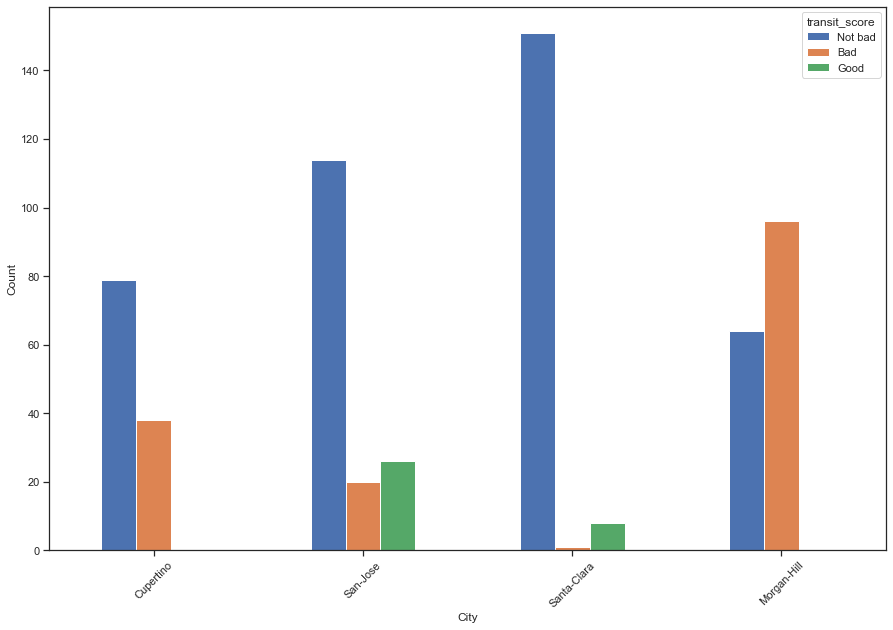

In [41]:
transit_desc_list = []
for t in homes_df['transit_score']:
    if t <= 100 and t >= 90:
        transit_desc_list.append('Excellent')
    elif t <= 89 and t >= 70:
        transit_desc_list.append('Better')
    elif t <= 69 and t >= 50:
        transit_desc_list.append('Good')
    elif t <= 49 and t >= 25:
        transit_desc_list.append('Not bad')
    elif t <= 24 and t >= 0:
        transit_desc_list.append('Bad')
    else:
        transit_desc_list.append('')
homes_df['transit_score'] =transit_desc_list
g = pd.crosstab(homes_df['City'], homes_df['transit_score'])
City_list = ['Cupertino','San-Jose','Santa-Clara','Morgan-Hill']
unique_ts = list(homes_df['transit_score'].unique())
g.loc[City_list, unique_ts].plot.bar(figsize=(15,10))
plot.xlabel('City')
plot.ylabel('Count')
plot.xticks(rotation=45)

### <font color = 'teal'> 11. Correlation between walkscore and price

Text(0.5, 1.0, 'Correlation between Price and WalkScores')

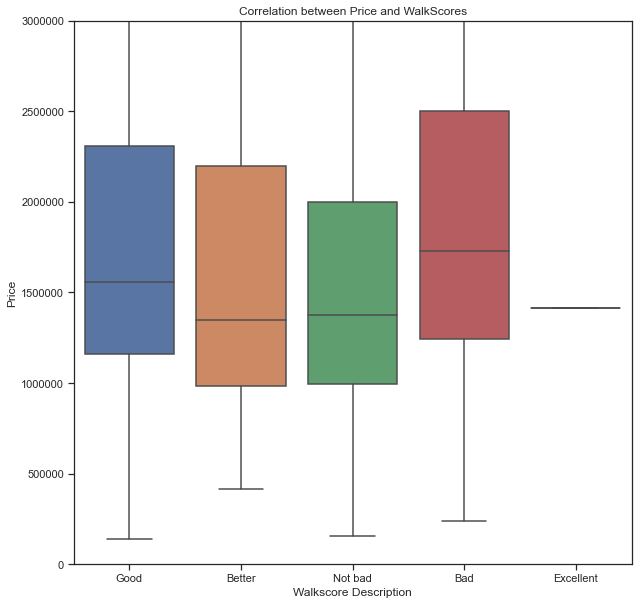

In [44]:
# Price range based on the walkscore and bikescore (averaged for each county)

plot.figure(figsize=(10,10))
sns.boxplot(x="walkscore_desc", y="Price", data=homes_df)
plot.ticklabel_format(style='plain', axis='y')
plot.ylim(0, 3000000)
plot.ylabel("Price")
plot.xlabel("Walkscore Description")
plot.title("Correlation between Price and WalkScores")

### <font color = 'teal'> 12. Correlation between bikescore and price

Text(0.5, 1.0, 'Correlation between Price and BikeScores')

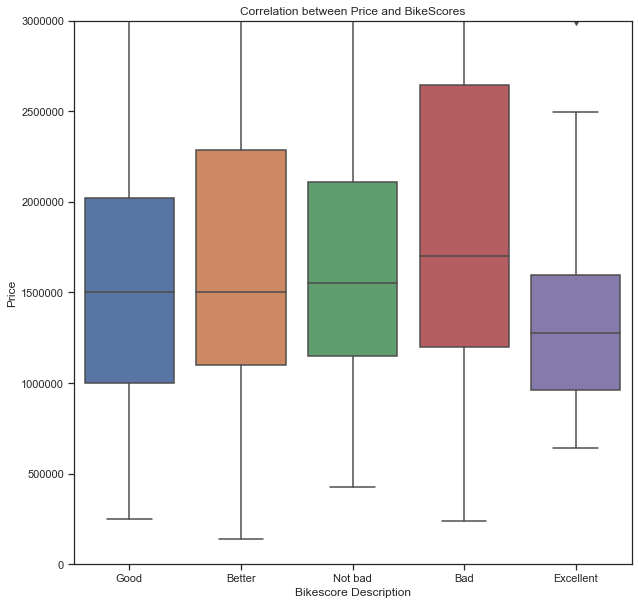

In [45]:
plot.figure(figsize=(10,10))
sns.boxplot(x="bikescore_desc", y="Price", data=homes_df)
plot.ticklabel_format(style='plain', axis='y')
plot.ylim(0, 3000000)
plot.ylabel("Price")
plot.xlabel("Bikescore Description")
plot.title("Correlation between Price and BikeScores")

### <font color = 'teal'> 13. Property Type vs No of properties

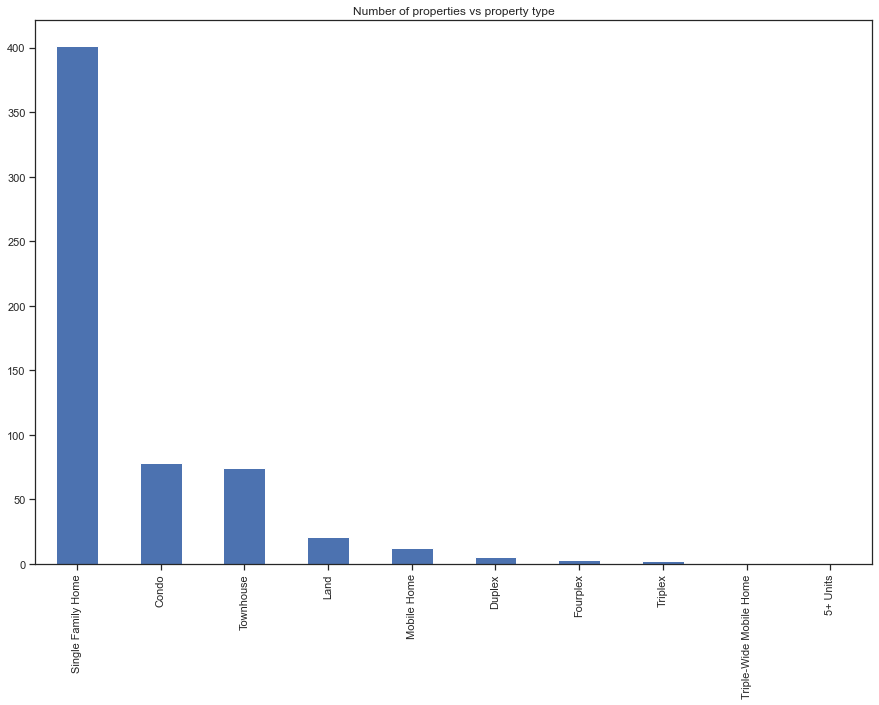

In [46]:
#Bar plot of Proeprty type category vs Number of properties
ax = homes_df['Property Type'].value_counts().plot(kind='bar',figsize=(15,10),
                                                      title='Number of properties vs property type')

### <font color = 'teal'> 14. Average Price of the houses across the year in which the property was built

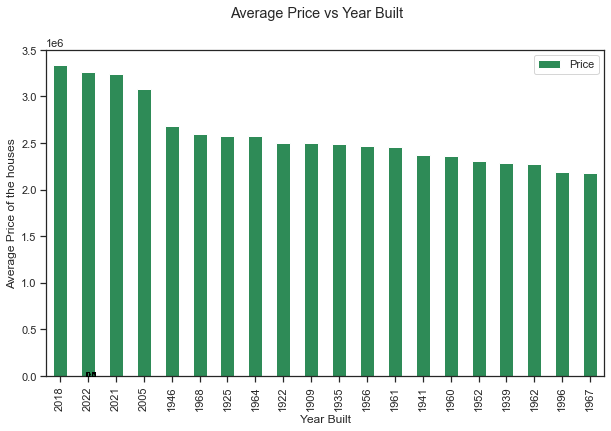

In [47]:

a = homes_df.groupby(by="Year Built")
b = pd.DataFrame(a['Price'].mean().round(2))
Top10 = pd.DataFrame(b.sort_values(by = 'Price',ascending=False).head(20))
Top10['Stack'] = 'Top'
 
# Horizontal Bar Plot
ax = Top10.plot(kind='bar',color='seagreen',figsize=(10,6))
plt.xlabel("Year Built")
plt.ylabel("Average Price of the houses") 

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.4, i.get_y()+0.1,
             str(round((i.get_width()), 2)),
             fontsize = 8, color ='black')
    
plt.suptitle('Average Price vs Year Built')
# Show Plot
plt.show()

### <font color = 'teal'> 15. Climate Factors and Price Correlation

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Cupertino'),
  Text(1, 0, 'Morgan-Hill'),
  Text(2, 0, 'San-Jose'),
  Text(3, 0, 'Santa-Clara')])

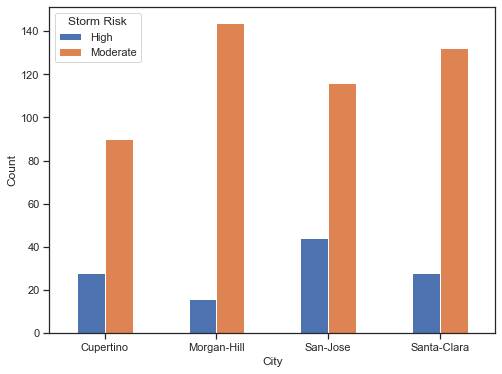

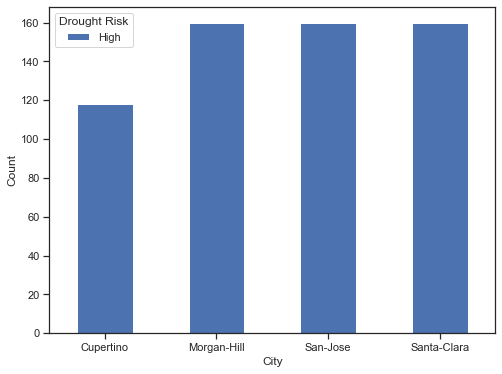

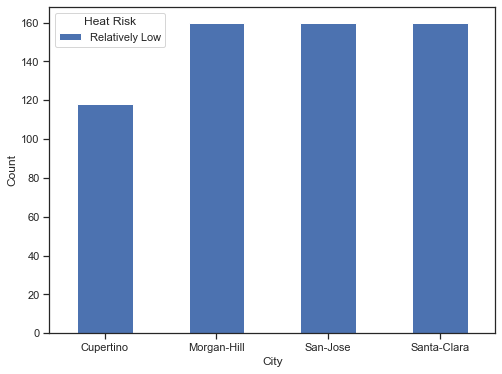

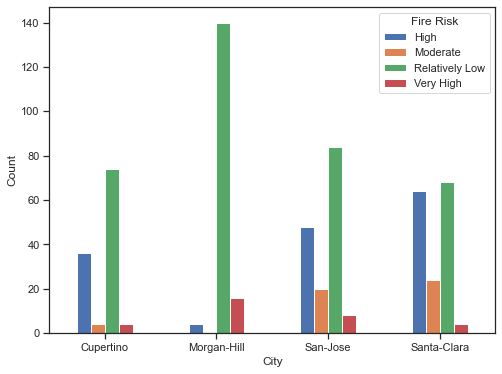

In [49]:
# Creating cross-tabulations for Climate factors to be compared with prices across 4 major cities

storm_risk_df = pd.crosstab(homes_df['City'], homes_df['Storm Risk'])
drought_risk_df = pd.crosstab(homes_df['City'], homes_df['Drought Risk'])
heat_risk_df = pd.crosstab(homes_df['City'], homes_df['Heat Risk'])
fire_risk_df = pd.crosstab(homes_df['City'], homes_df['Fire Risk'])

# Plotting all 4 climate factors against City
storm_risk_df.plot.bar(figsize=(8,6))
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=0)

drought_risk_df.plot.bar(figsize=(8,6))
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=0)

heat_risk_df.plot.bar(figsize=(8,6))
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=0)

fire_risk_df.plot.bar(figsize=(8,6))
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=0)



Text(0.5, 1.0, 'Correlation between Price and Fire Risk')

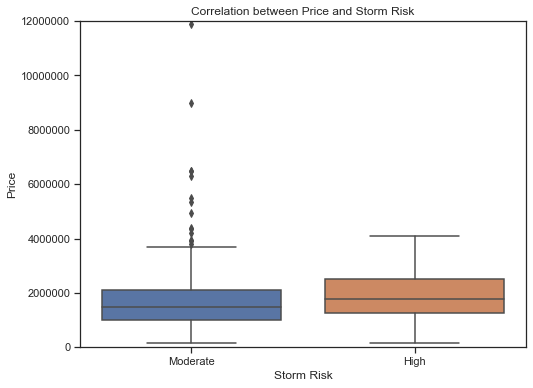

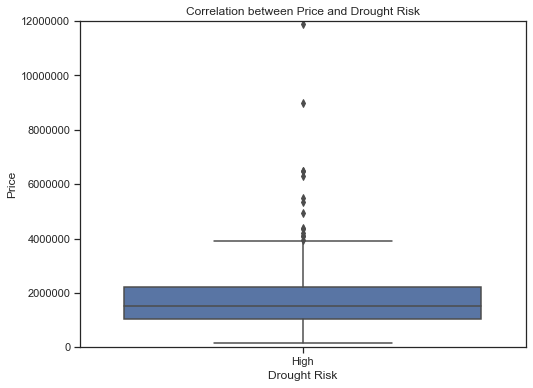

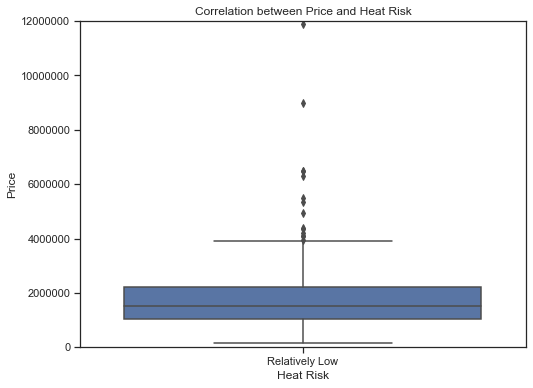

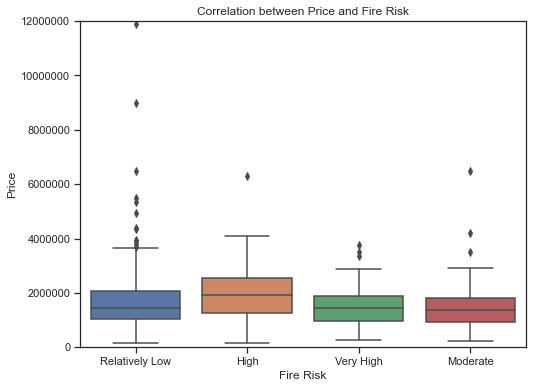

In [50]:
# Boxplot to see correlation between climate factors and prices

storm_risk_price = homes_df[['Storm Risk', 'Price']]
drought_risk_price = homes_df[['Drought Risk', 'Price']]
heat_risk_price = homes_df[['Heat Risk', 'Price']]
fire_risk_price = homes_df[['Fire Risk', 'Price']]

plt.figure(figsize=(8,6))
sns.boxplot(x="Storm Risk", y="Price", data=storm_risk_price)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 12000000)
plt.ylabel("Price")
plt.xlabel("Storm Risk")
plt.title("Correlation between Price and Storm Risk")

plt.figure(figsize=(8,6))
sns.boxplot(x="Drought Risk", y="Price", data=drought_risk_price)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 12000000)
plt.ylabel("Price")
plt.xlabel("Drought Risk")
plt.title("Correlation between Price and Drought Risk")

plt.figure(figsize=(8,6))
sns.boxplot(x="Heat Risk", y="Price", data=heat_risk_price)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 12000000)
plt.ylabel("Price")
plt.xlabel("Heat Risk")
plt.title("Correlation between Price and Heat Risk")

plt.figure(figsize=(8,6))
sns.boxplot(x="Fire Risk", y="Price", data=fire_risk_price)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 12000000)
plt.ylabel("Price")
plt.xlabel("Fire Risk")
plt.title("Correlation between Price and Fire Risk")

Text(0.5, 1.0, 'Correlation between Price and Cities ')

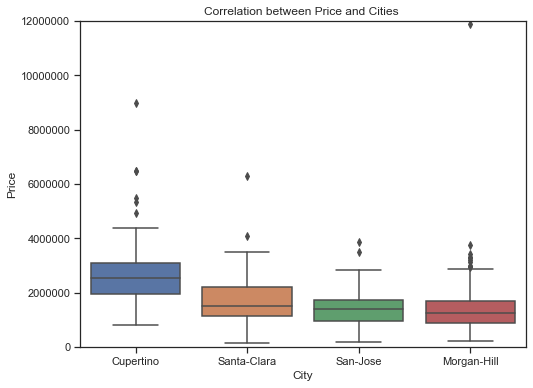

In [53]:
# Boxplot to see correlation between climate factors and prices across cities

city_price = homes_df[['City', 'Price']]

plt.figure(figsize=(8,6))
sns.boxplot(x="City", y="Price", data=city_price)
plt.ticklabel_format(style='plain', axis='y')
plt.ylim(0, 12000000)
plt.ylabel("Price")
plt.xlabel("City")
plt.title("Correlation between Price and Cities ")

### <font color = 'teal'> City Level Data Visualizations and Analysis

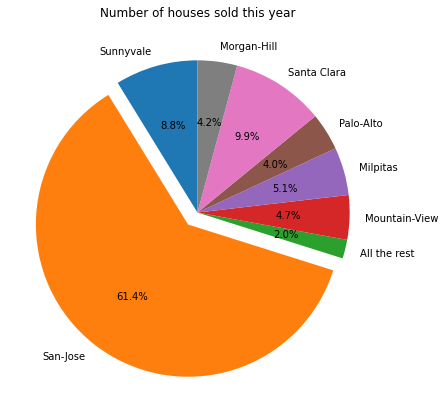

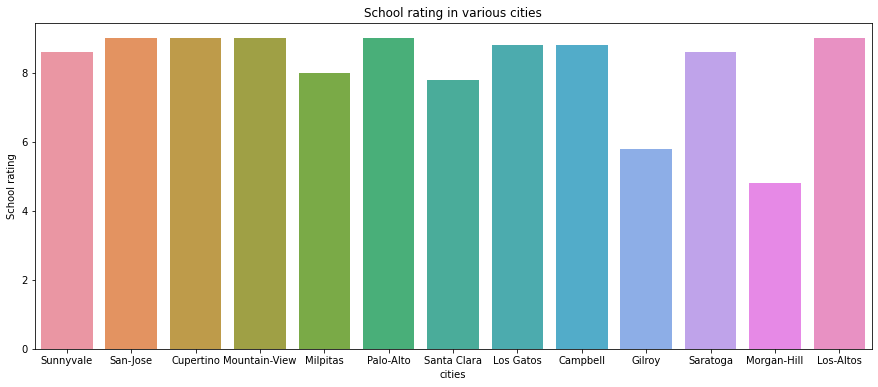

In [3]:
#Data Visualiazation for city level data
#pie chart to analyze which city sold more houses this year
import matplotlib.pyplot as plt 
import pandas as pd
df=pd.read_excel('Cities statistics.xlsx','Cities statistics',engine='openpyxl',index_col=0)
#print(df)
stats= {"Competitive_Score":[],"#of houses sold":[],"Home sold above list price":[],"School rating":[]}
stats["Competitive_Score"] = list(df.iloc[:,0].values)
stats["#of houses sold"] = list(df.iloc[:,1].values)
stats["Home sold above list price"] = list(df.iloc[:,2].values)
stats["School rating"] = list(df.iloc[:,3].values)
statshouses= dict(zip(list(df.index), [int(i) for i in stats["#of houses sold"]]))
fig1, ax1 = plt.subplots(figsize=(7, 7))
explode = (0, 0.1, 0, 0,0,0,0,0) 

import itertools
newstats={}
for key, group in itertools.groupby(statshouses, lambda k: 'All the rest' if (statshouses[k]<50) else k):
     newstats[key] = sum([statshouses[k] for k in list(group)]) 

labels = newstats.keys()
sizes = newstats.values()
plt.pie(sizes,labels = labels,startangle=90,autopct='%.1f%%',explode=explode)
plt.title("Number of houses sold this year")
plt.savefig('City_Performance', bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='b',
            orientation ='landscape')
plt.show()


#bar chart to see which city has best schools
fig, ax = plt.subplots(figsize=(15, 6))
import seaborn as sns
sns.barplot(x=df.index,y = "School rating",data = df,orient='v')
plt.title("School rating in various cities")
plt.savefig('School rating',bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='b',
            orientation ='landscape')
ax.set(xlabel='cities', ylabel='School rating')
plt.show()



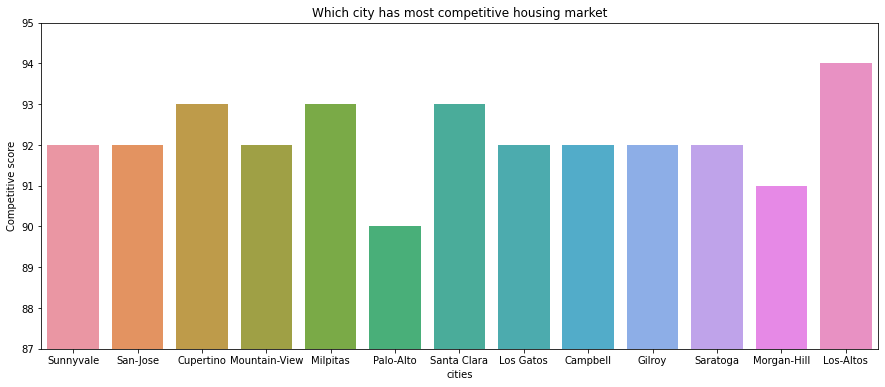

In [4]:
#bar chart to see which competitivenes between cities
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(x=df.index,y = "Competitive_Score",data = df,orient='v')
plt.title("Which city has most competitive housing market")
ax.set_ylim(87, 95)
plt.savefig('Competitive score',bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='b',
            orientation ='landscape',)

ax.set(xlabel='cities', ylabel='Competitive score')
plt.show()

In [56]:
df["Home sold above list price"] = df["Home sold above list price"].astype(float).fillna(0.0)

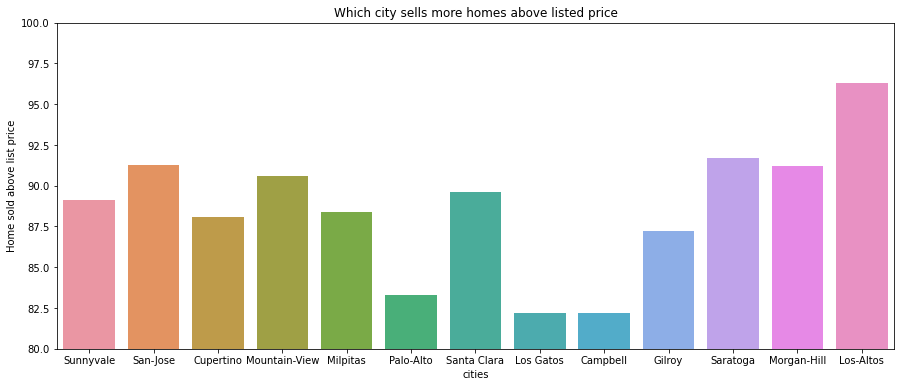

In [5]:
#bar chart to see which competitivenes between cities
fig, ax = plt.subplots(figsize=(15, 6))
#df."Home sold above list price" = df."Home sold above list price".astype(float).fillna(0.0)
sns.barplot(x=df.index,y = "Home sold above list price",data = df,orient='v')
plt.title("Which city sells more homes above listed price")
plt.savefig('Home sold above list price',bbox_inches ="tight",
            pad_inches = 1,
            transparent = True,
            facecolor ="w",
            edgecolor ='b',
            orientation ='landscape',)
ax.set_ylim(80, 100)
ax.set(xlabel='cities', ylabel='Home sold above list price')
plt.show()